# Temporal auto-correlation

Assessment of model temporal auto-correlation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import statsmodels.api as sm

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
def calc_tac(da, var):
    """Calculate the lag1 auto-correlation"""
    
    if var == 'pr':
        ds = da.groupby('time.year').sum(dim='time')
        
    else:
        ds = da.groupby('time.year').mean(dim='time')

    lag1_annual_autocorrelation = sm.tsa.acf(ds.values, nlags = len(ds.values)-1)
        
    return  lag1_annual_autocorrelation

In [3]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_dict['obs'] = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
   
    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [4]:
cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},    
}
colours=['bo','co','go','ro','mo','ko']

In [5]:
def plot_city(ax, xticks, var, da, city, colour,  name):
    """Plot ACF"""
    da_point = da.sel(cities[city], method='nearest')
    lag1_tac = calc_tac(da_point, var)
    # ax.plot(xticks, lag1_tac, label=name, marker='o',linewidth=0.8, markersize=2)
    ax.stem(xticks, lag1_tac, 'grey', markerfmt = colour, label=name)

In [6]:
def plot_city_tac(var, gcm, rcm, task):
    """Plot ACF for a bunch of cities"""
        
    da_dict = get_data(var, gcm, rcm, task)
    
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980' 
    end_year = '2019'
  
    xticks = np.arange(0,len(np.arange(int(start_year), int(end_year)+1)))
    xtick_labels = [np.arange(int(start_year), int(end_year)+1)[i] for i in xticks]
    
    fig = plt.figure(figsize=[20, 48])
    for plotnum, city in enumerate(cities):
        ax = fig.add_subplot(6, 2, plotnum+1)
        plot_city(ax, xticks, var, da_dict['obs'], city, colours[0], 'AGCD')
        plot_city(ax, xticks, var, da_dict['gcm'], city, colours[1], gcm)
        plot_city(ax, xticks, var, da_dict['rcm_raw'], city, colours[2], rcm)
        plot_city(ax, xticks, var, da_dict['rcm_ecdfm'], city, colours[3], f'{rcm} (ECDFm)')
        plot_city(ax, xticks, var, da_dict['rcm_qme'], city, colours[4], f'{rcm} (QME)')
        if task == 'xvalidation':
            plot_city(ax, xticks, var, da_dict['rcm_qdm'], city, colours[5], f'{rcm} (QDM)')
        ax.set_title(city)
        ax.set_ylabel(f'Autocorrelation Function (ACF)')
        ax.set_xticks(xticks, xtick_labels, rotation=90)
        # if plotnum == 0:
        ax.legend()
        ax.grid(axis='y', which='major', color='grey', linewidth=0.3, linestyle=':')

    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Annual temporal auto-correlation in the {start_year}-2019 {long_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [7]:
variable = 'tasmax'

### ERA5

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'historical')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'historical')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'historical')

### ACCESS-ESM1-5

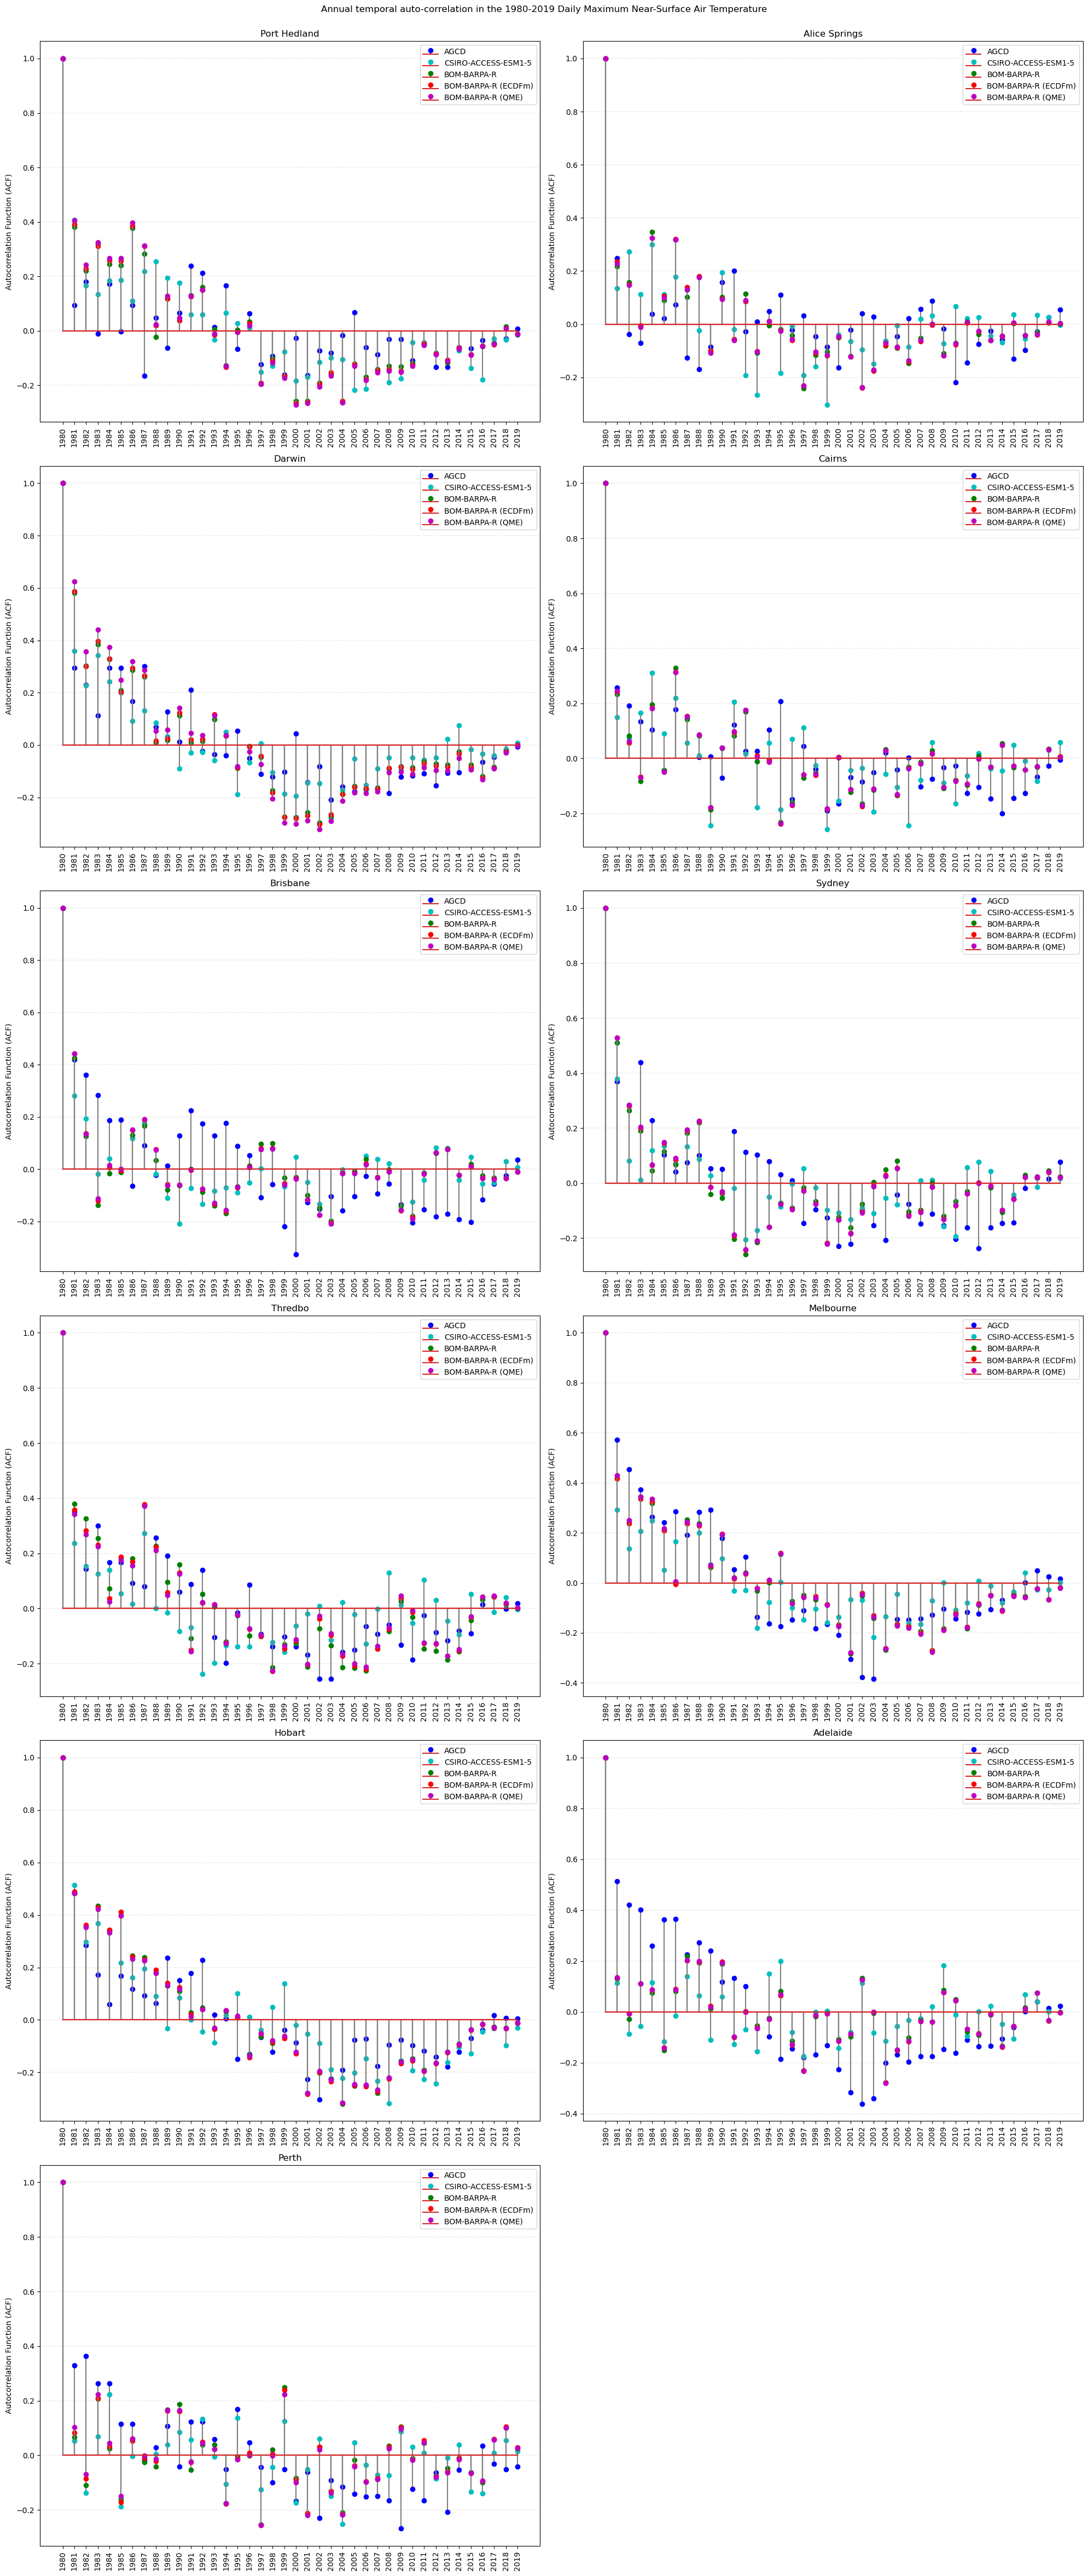

In [8]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical')

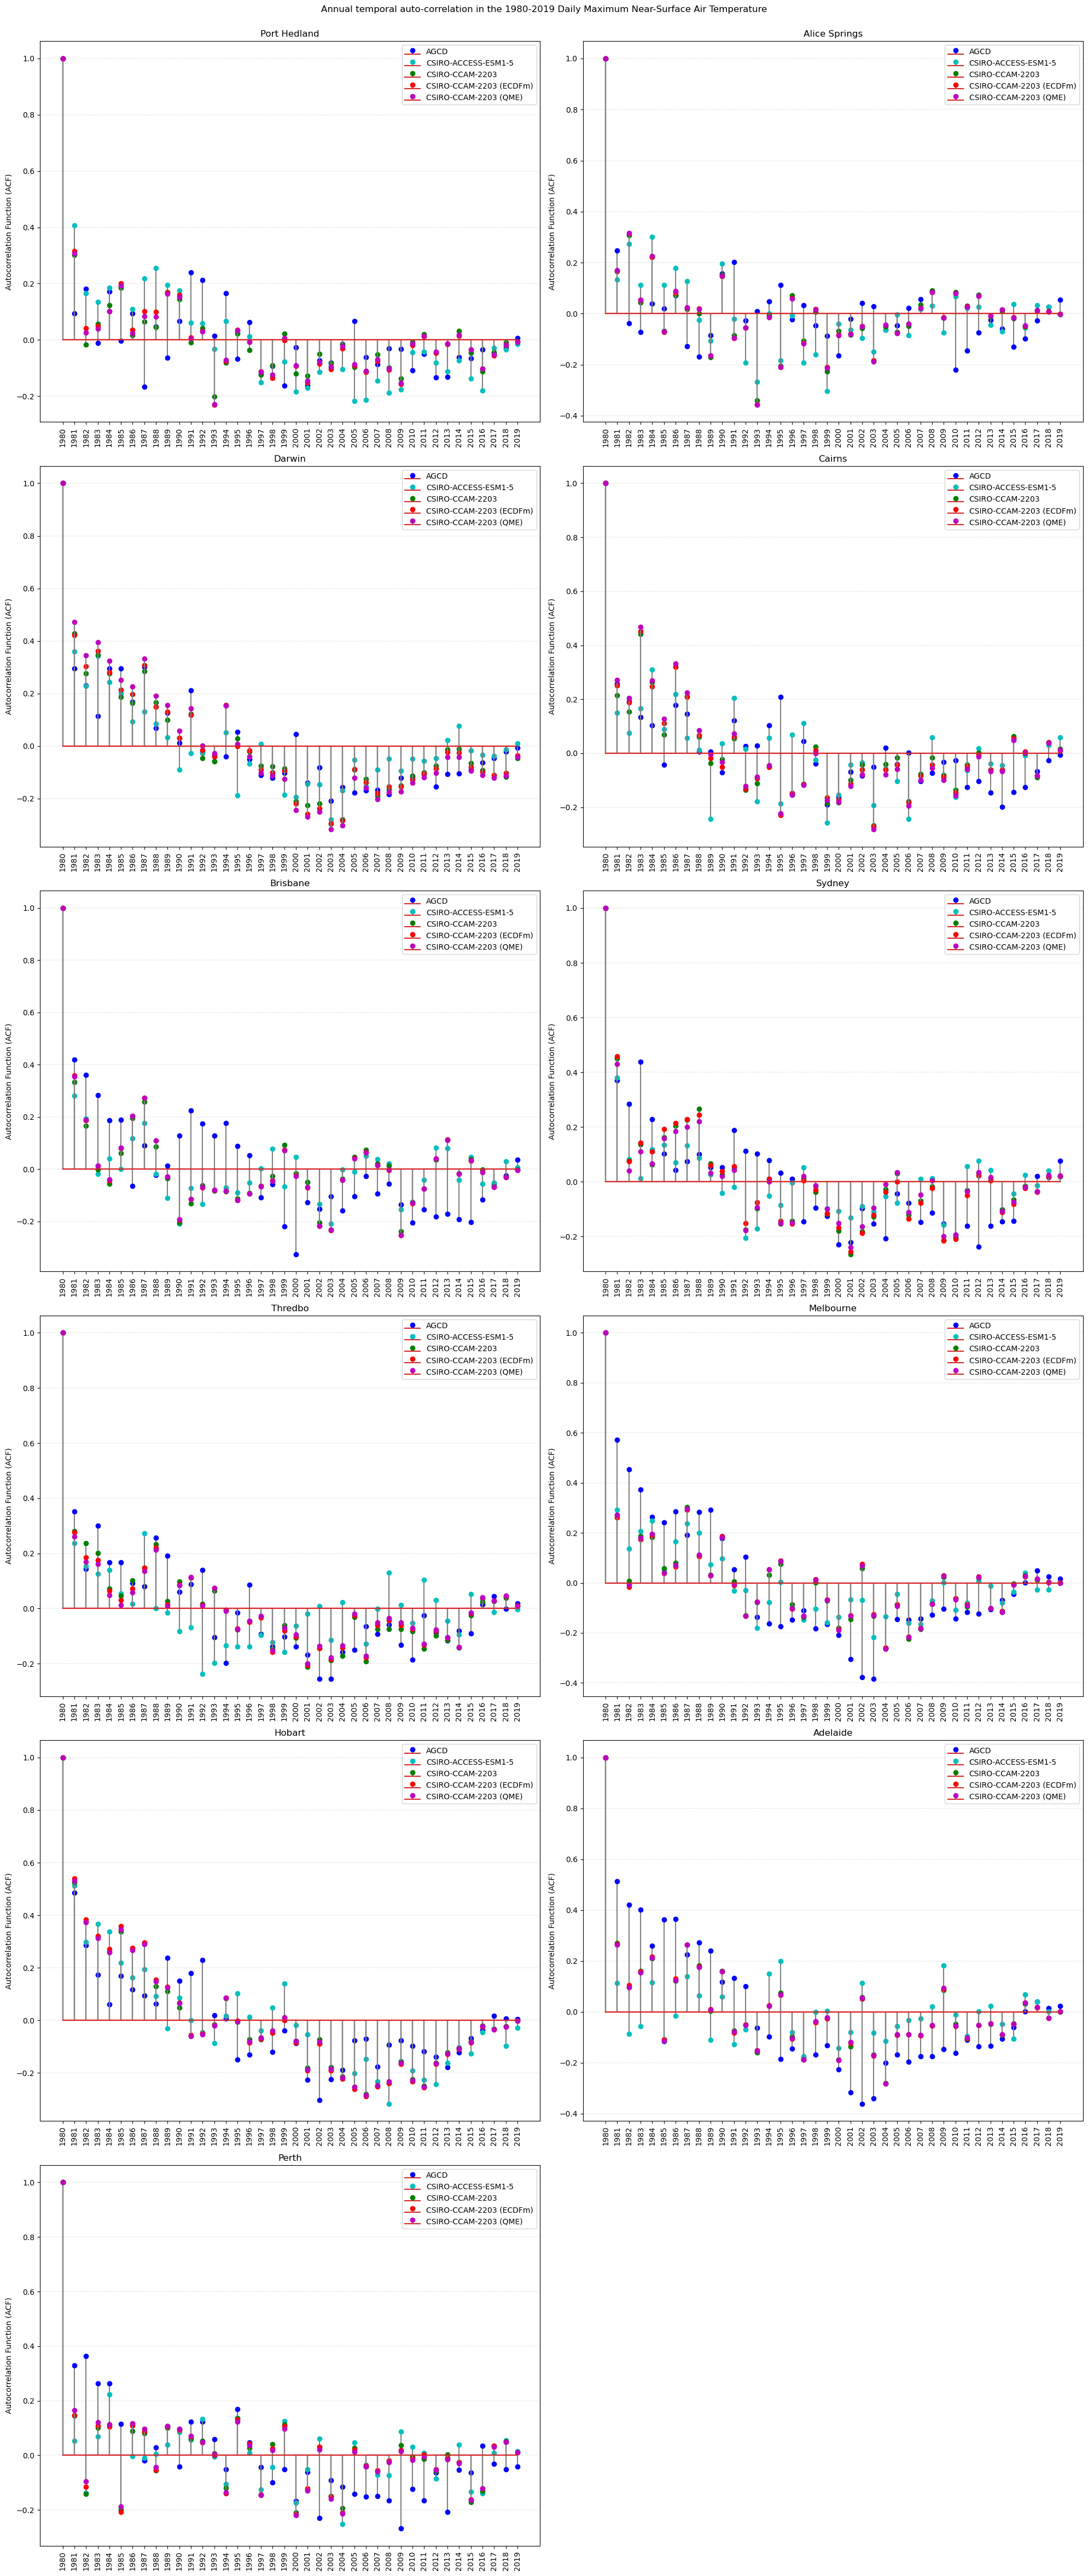

In [9]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical')

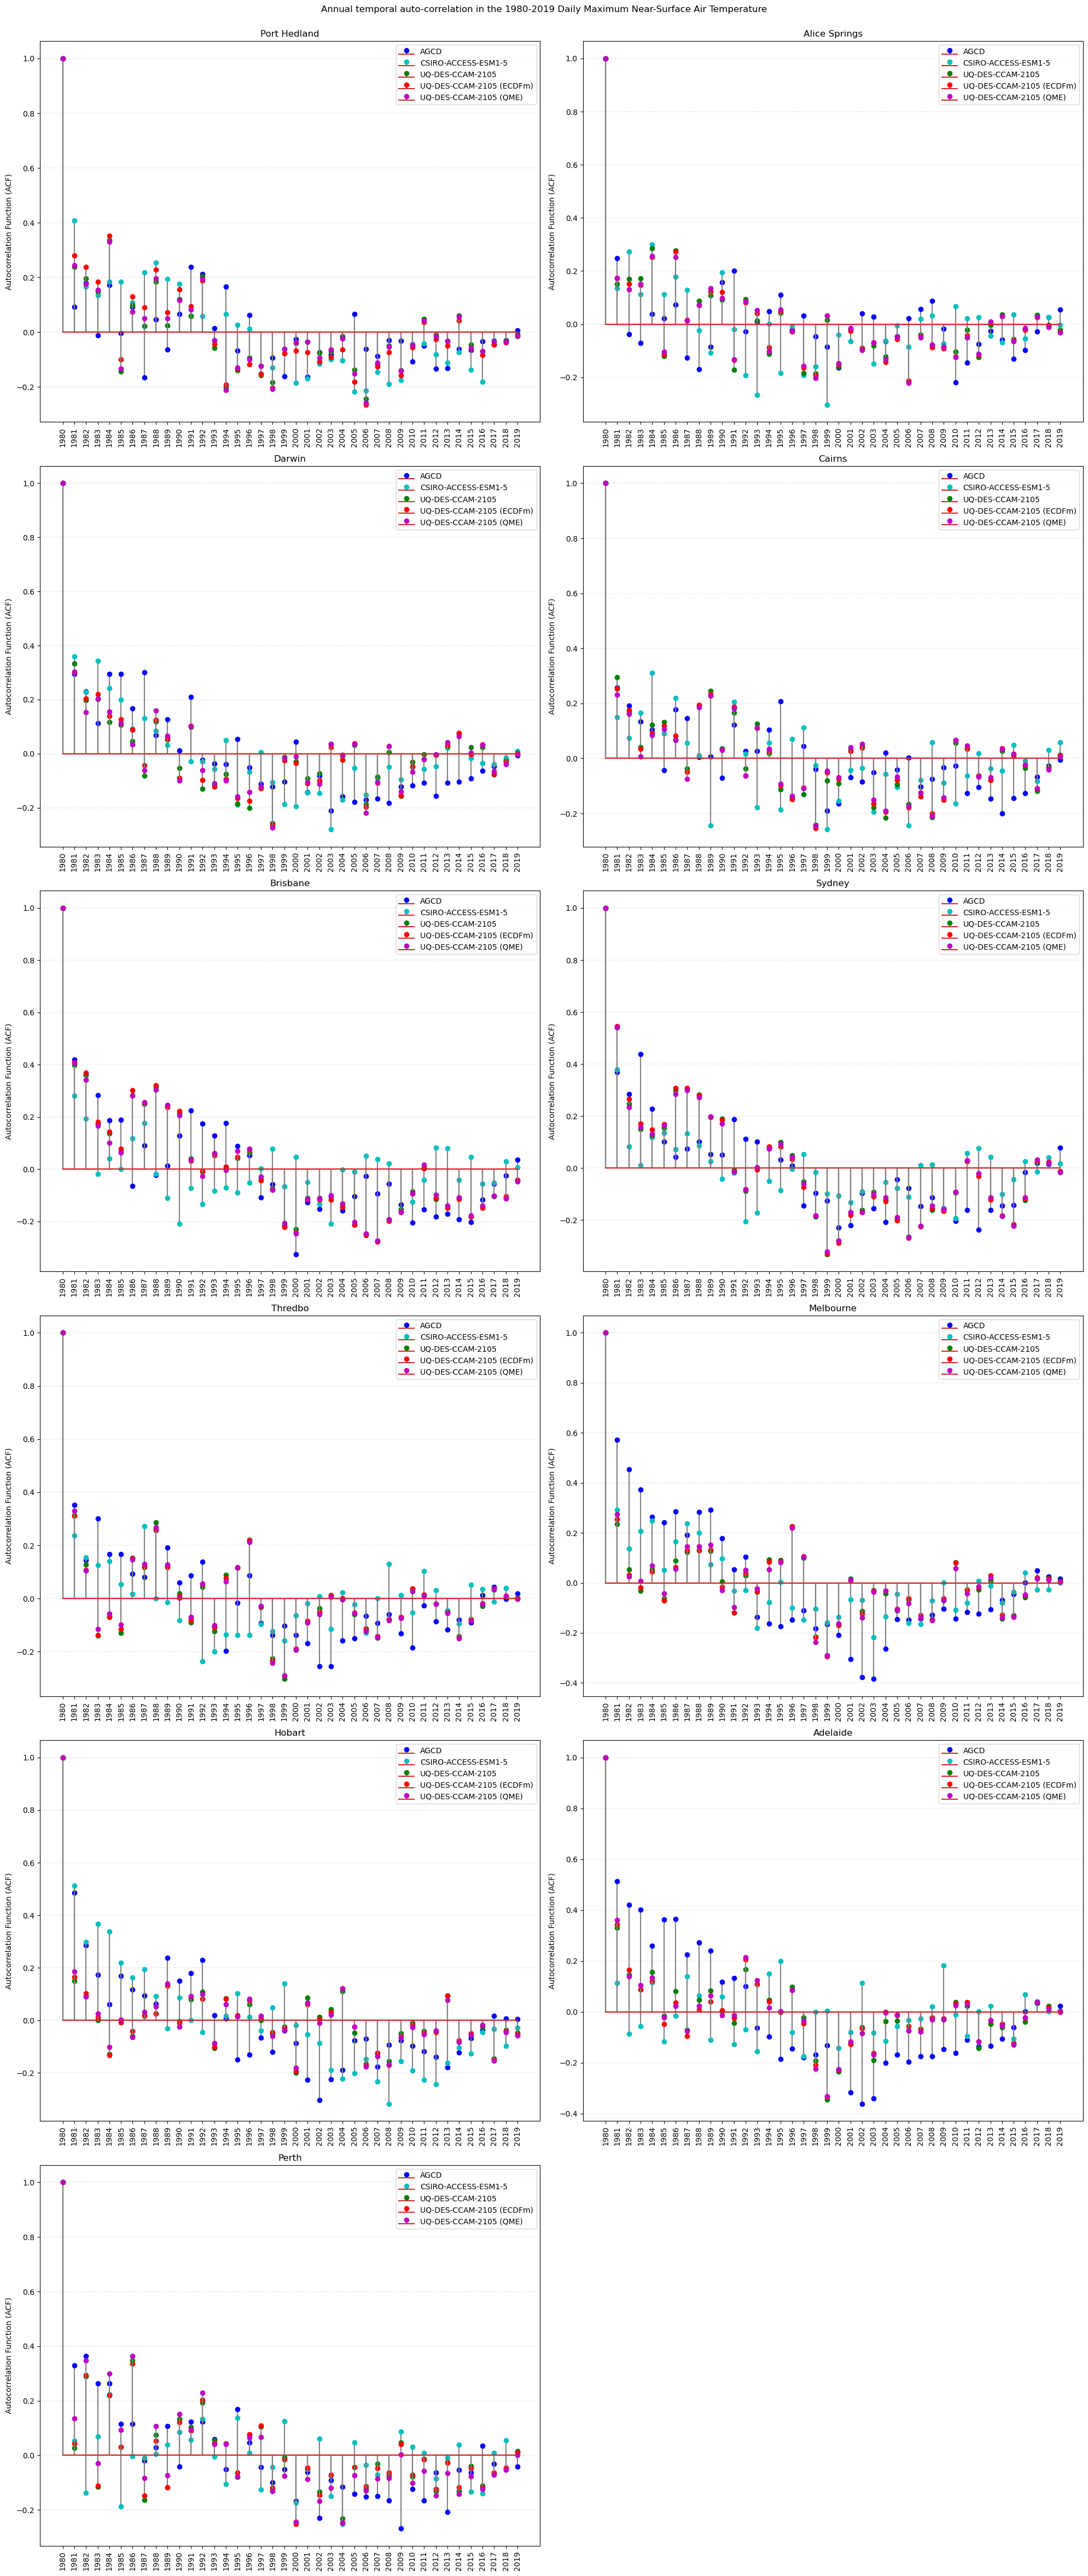

In [10]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical')

# task-xvalidation

### ERA5
Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'xvalidation')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'xvalidation')

In [ ]:
plot_city_tac(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'xvalidation')

### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

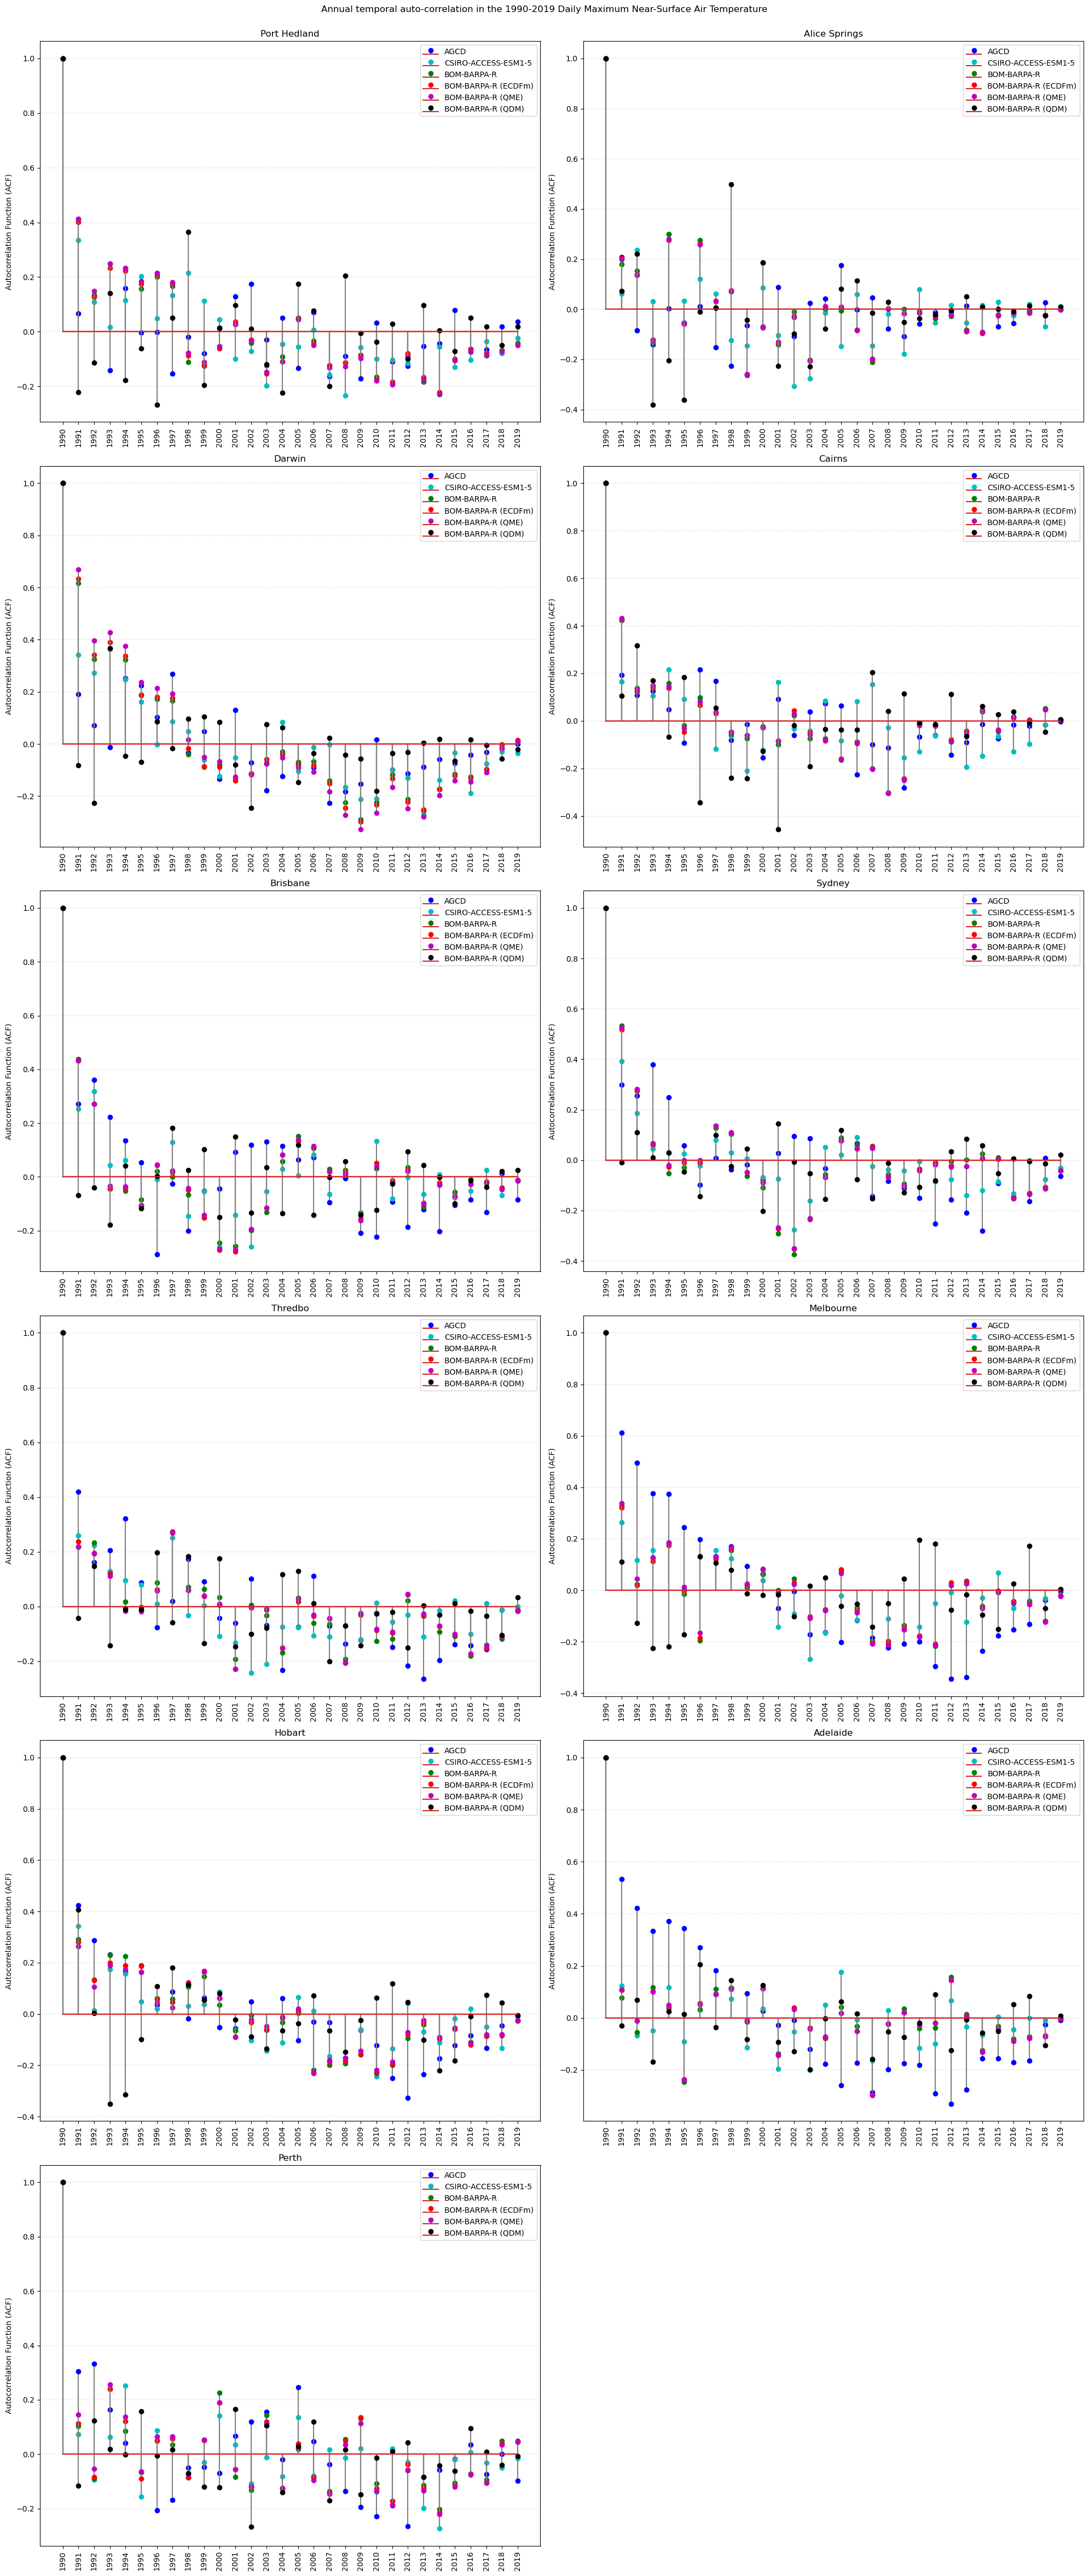

In [11]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation')

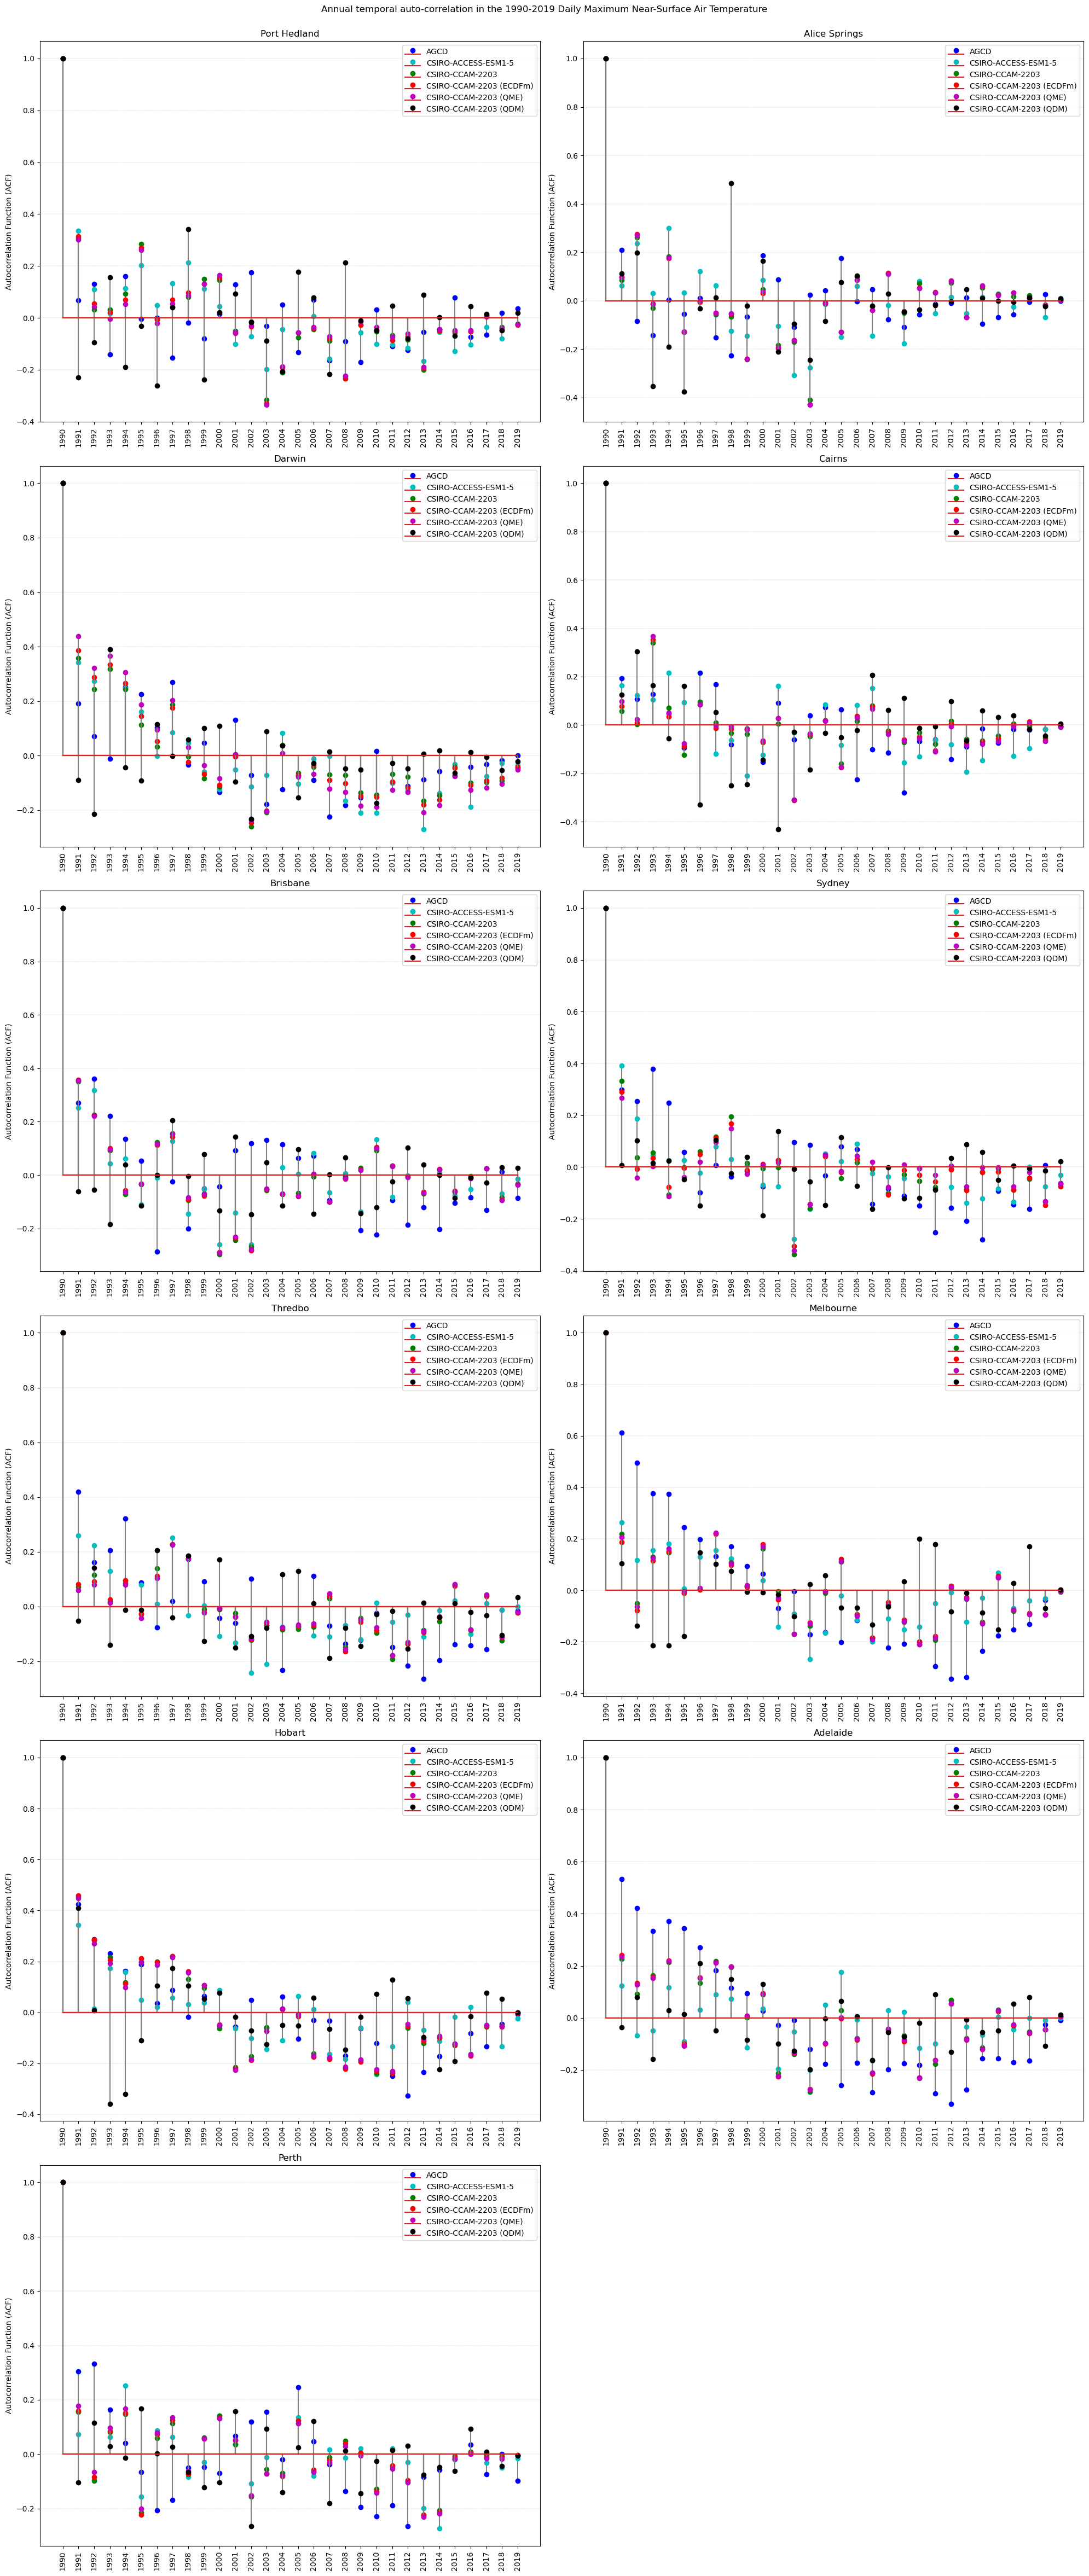

In [12]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation')

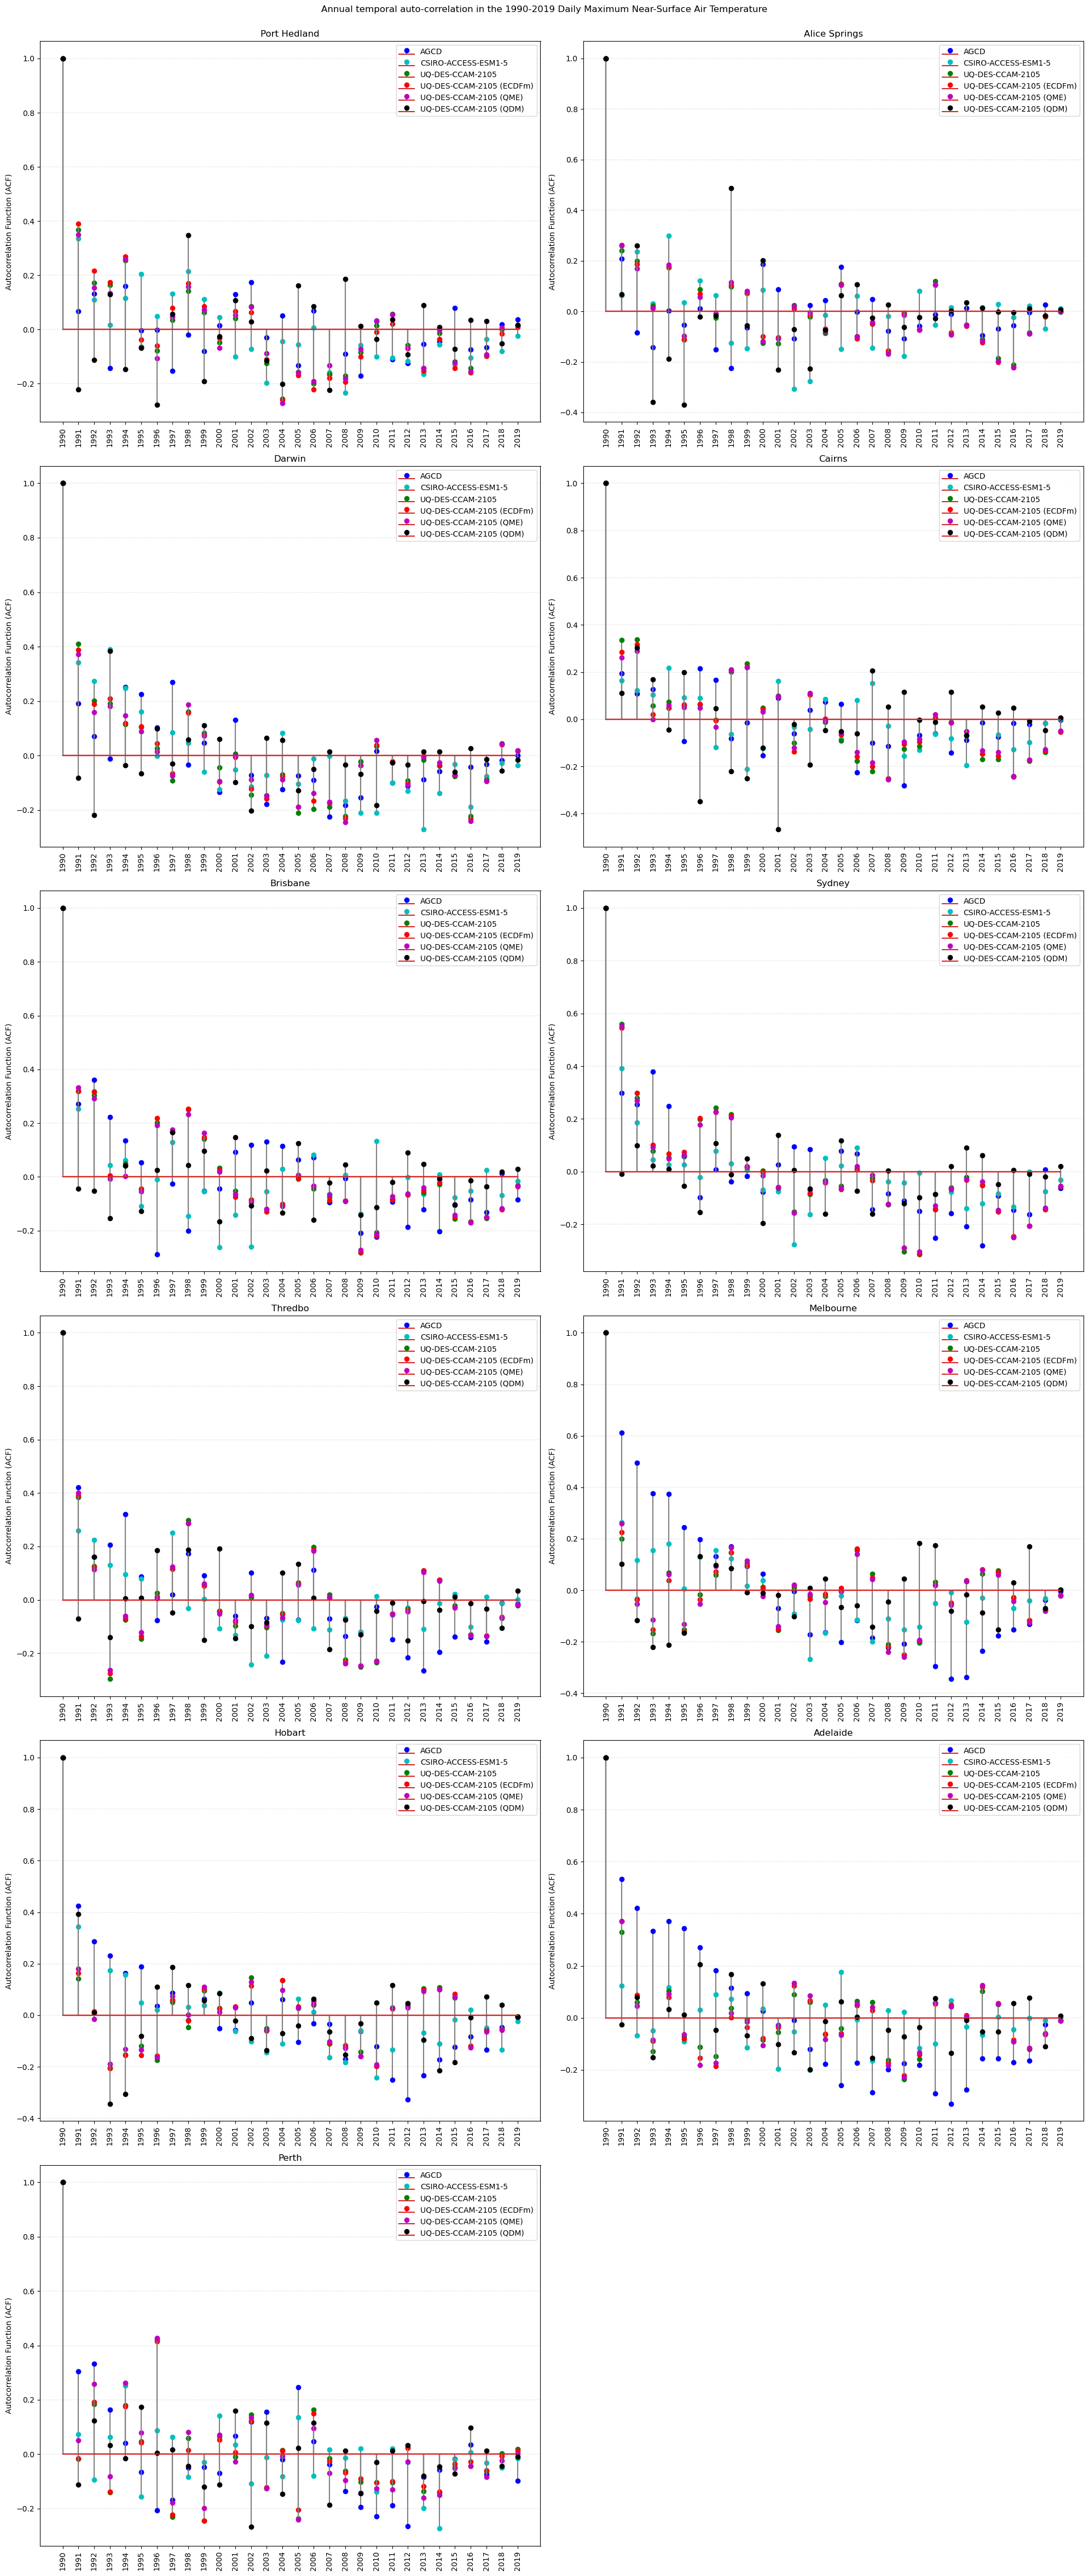

In [13]:
plot_city_tac(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation')